<a href="https://colab.research.google.com/github/theoVasilas/NN_training/blob/main/MINIST_CNN_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## dowload dataset and imports

In [ ]:
%%capture
%pip install torch
%pip install torchvision
#captured_output.show()

In [ ]:
%%capture
%pip install matplotlib

In [ ]:
import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

from IPython.utils import io
import numpy as np


In [ ]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [ ]:
from torchvision import datasets
from torchvision.transforms import ToTensor

train_data = datasets.MNIST(
    root = 'data',
    train = True,
    transform = ToTensor(),
    download = True,
)
test_data = datasets.MNIST(
    root = 'data',
    train = False,
    transform = ToTensor()
)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 35415050.69it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 1106221.63it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 9349526.36it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 3585644.41it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [ ]:
print(train_data.data.size())
print(test_data.data.size())

torch.Size([60000, 28, 28])
torch.Size([10000, 28, 28])


## tranforms


In [ ]:
from torchvision import transforms

transform_train = transforms.Compose([
    # transforms.RandomAffine(degrees=5, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=10),
    transforms.ToTensor()
])

transform_test = transforms.Compose([
    transforms.ToTensor()
])


train_data = datasets.MNIST(
    root = 'data',
    train = True,
    download = False,
    transform = transform_train
)
test_data = datasets.MNIST(
    root = 'data',
    train = False,
    download = False,
    transform=transform_test
)

## loaders

In [ ]:
from torch.utils.data import DataLoader, random_split

batch_size = 100

train_size = int(0.8 * len(train_data))
val_size = len(train_data) - train_size
train_data, val_data = random_split(train_data, [train_size, val_size])

data_loaders = {
    'train' : torch.utils.data.DataLoader(train_data,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          num_workers=1),

    'test'  : torch.utils.data.DataLoader(test_data,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          num_workers=1),

    'valid' : torch.utils.data.DataLoader(val_data,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          num_workers=1)
}


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


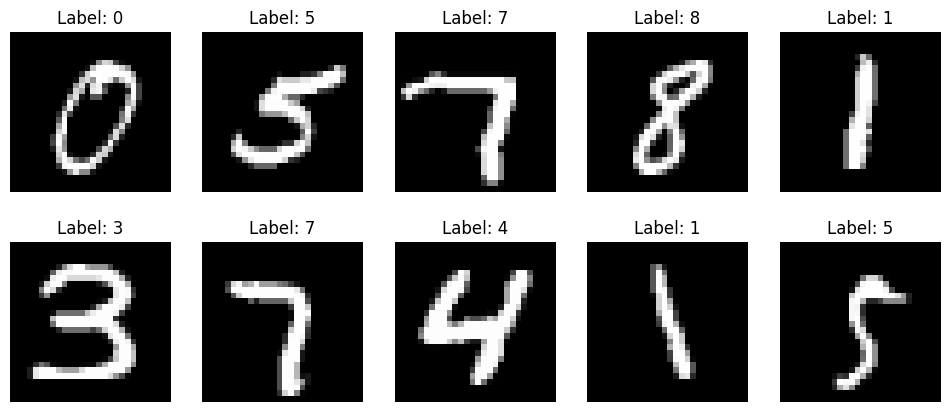

In [ ]:
train_loader = data_loaders['train']
data_iter = iter(train_loader)

# Plot 10 images
fig, axes = plt.subplots(2, 5, figsize=(12, 5))

for i in range(10):
    images, labels = next(data_iter)
    ax = axes[i // 5, i % 5]
    ax.imshow(images[0].permute(1, 2, 0).squeeze(), cmap='gray')  # Assuming images are in CHW format
    ax.set_title(f"Label: {labels[0]}")
    ax.axis('off')

plt.show()

## costume dropout func

In [ ]:
class CustomDropout(nn.Module):
    def __init__(self):
        super(CustomDropout, self).__init__()

    def forward(self, x, p):
        if self.training:
            # Generate a binary mask with probability (1 - p)
            mask = torch.bernoulli(torch.ones_like(x) * (1 - p))
            # Scale the output by 1 / (1 - p) to maintain the expected value
            return x * mask / (1 - p)
        else:
            return x

## Simple CNN

In [ ]:
import torch.nn as nn
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=1,
                out_channels=16,
                kernel_size=5,
                stride=1,
                padding=2,
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, 5, 1, 2),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        # fully connected layer, output 10 classes
        self.out = nn.Linear(32 * 7 * 7, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)
        output = self.out(x)
        return output


cnn_1 = CNN().to(device)

## My_CNN

In [ ]:
# %%capture
# %pip install torchviz

# import torch
# from torchviz import make_dot

# dummy_input = torch.randn(1, 1, 28, 28).to(device)

# dot = make_dot(Cnet(dummy_input), params=dict(Cnet.named_parameters()))

# dot.render("CNN_visualization", format="pdf")

# dot

In [ ]:
import torch.nn.init as init
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self, num_classes, dropout_p =0):
        super(Net, self).__init__()

        self.conv1 = nn.Conv2d(
            in_channels=1,
            out_channels=16,
            kernel_size=5,
            stride=1,
            padding=2,
        )
        self.relu1 = nn.ReLU()
        self.dropout1 = CustomDropout()
        init.xavier_uniform_(self.conv1.weight)

        self.conv2 = nn.Conv2d(
            in_channels=16,
            out_channels=24,
            kernel_size=3,
            stride=1,
            padding=1,
        )
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        self.dropout2 = CustomDropout()
        init.xavier_uniform_(self.conv2.weight)

        self.conv3 = nn.Conv2d(
            in_channels=24,
            out_channels=32,
            kernel_size=2,
            stride=1,
            padding=1,
        )
        self.relu3 = nn.ReLU()
        self.maxpool3 = nn.MaxPool2d(kernel_size=2)
        self.dropout3 = CustomDropout()
        init.xavier_uniform_(self.conv3.weight)

        self.linear1 = nn.Linear(in_features=32 * 7 * 7, out_features=24)
        init.xavier_uniform_(self.linear1.weight)

        self.linear2 = nn.Linear(in_features=24, out_features=num_classes)
        init.xavier_uniform_(self.linear2.weight)

        self.dropout_p = dropout_p

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.dropout1(x, self.dropout_p)

        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)
        x = self.dropout2(x, self.dropout_p)

        x = self.conv3(x)
        x = self.relu3(x)
        x = self.maxpool3(x)
        x = self.dropout3(x, self.dropout_p)

        x = x.view(x.size(0), -1)
        x = F.relu(self.linear1(x))
        x = self.linear2(x)
        return x

    @property
    def dropout_p(self):
        return self._dropout_p

    @dropout_p.setter
    def dropout_p(self, value):
        if hasattr(self, '_dropout_p'):
            if value != self._dropout_p:
                print(f"Dropout rate changed to: {value}")
        self._dropout_p = value

    def reset_weights(self):
        for module in self.modules():
            if isinstance(module, nn.Conv2d) or isinstance(module, nn.Linear):
                init.xavier_uniform_(module.weight)


Cnet = Net(num_classes=10).to(device)
Cnet.reset_weights()


## parametrs

In [ ]:
from torch import optim

learning_rate = 0.001
loss_func = nn.CrossEntropyLoss()

## training

In [ ]:
import torch
from torch.autograd import Variable


def my_train(model,
            loaders = None,
            num_epochs = 20,
            loss_func = None,
            optimizer = None,
            patience=5,
            save_path=None,
            dropout_rate=None):

    model.train()
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    best_val_loss = 9999


    for epoch in range(num_epochs):


        # Training
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        for i, (images, labels) in enumerate(loaders['train']):

            b_x = Variable(images).to(device)   # batch x
            b_y = Variable(labels).to(device)   # batch y

            output = model(b_x)
            loss = loss_func(output, b_y)
            running_loss += loss.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if (i+1) % 100 == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                       .format(epoch + 1, num_epochs, i + 1, len(loaders['train']), loss.item()))
            pass

            _, predicted_train = torch.max(output.data, 1)
            total_train += b_y.size(0)
            correct_train += (predicted_train == b_y).sum().item()
        pass

        train_loss = running_loss / len(loaders['train'])
        train_accuracy = 100 * correct_train / total_train

        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # Validation
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for images, labels in loaders['valid']:

                b_x = Variable(images).to(device)   # batch x
                b_y = Variable(labels).to(device)   # batch y

                output = model(b_x)
                loss = loss_func(output, b_y)
                val_loss += loss.item()

                _, predicted_val = torch.max(output.data, 1)
                total_val += b_y.size(0)
                correct_val += (predicted_val == b_y).sum().item()
            pass
        pass

        val_loss /= len(loaders['valid'])
        val_accuracy = 100 * correct_val / total_val

        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f"Epoch [{epoch + 1}/{num_epochs}], "
              f"Train Loss: {train_loss:.4f}, "
              f"Train Accuracy: {train_accuracy:.2f}%, "
              f"Val Loss: {val_loss:.4f}, "
              f"Val Accuracy: {val_accuracy:.2f}%")

        # Early stopping check
        if val_loss < best_val_loss * 0.9:
            best_val_loss = val_loss

            no_improvement_count = 0

            #save best model
            if save_path :
                # torch.save(best_model_state_dict, save_path)
                torch.save(model, save_path )
            pass

        else:
            no_improvement_count += 1
            print("no improvment")
            if no_improvement_count >= patience:
                print(f"No improvement in validation loss for {patience} epochs. Stopping training.")
                break
        pass



        if train_loss < 0.01 :
            print('dropout active')
            model.dropout_p = dropout_rate
        else:
            print('dropout disabled')
            model.dropout_p = 0


        # change dropout rate
        if val_accuracy > 80 or (val_accuracy > train_accuracy) :
            model.dropout_p = 0.8
            print("increce dropout rate to 0.3")
        else:
            model.dropout_p = 0
        pass


    # Plotting
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
    plt.plot(range(1, len(val_losses) + 1), val_losses, label='Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Train Accuracy')
    plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Val Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.show()

In [ ]:
save_path = 'CNN_1_trained_model_5.pt'
optimizer = optim.Adam(cnn_1.parameters(), lr = 0.001)

my_train(cnn_1, num_epochs = 5, patience=10, save_path=save_path , dropout_rate = 0.0,
         loaders = data_loaders, optimizer = optimizer, loss_func = loss_func)

Epoch [1/50], Step [100/480], Loss: 0.3096
Epoch [1/50], Step [200/480], Loss: 0.1580
Epoch [1/50], Step [300/480], Loss: 0.0478
Epoch [1/50], Step [400/480], Loss: 0.1766
Epoch [1/50], Train Loss: 0.2862, Train Accuracy: 91.76%, Val Loss: 0.0888, Val Accuracy: 97.34%
dropout disabled
increce dropout rate to 0.3
Epoch [2/50], Step [100/480], Loss: 0.2845
Epoch [2/50], Step [200/480], Loss: 0.1019
Epoch [2/50], Step [300/480], Loss: 0.0728
Epoch [2/50], Step [400/480], Loss: 0.0819
Epoch [2/50], Train Loss: 0.0764, Train Accuracy: 97.70%, Val Loss: 0.0619, Val Accuracy: 98.08%
dropout disabled
increce dropout rate to 0.3
Epoch [3/50], Step [100/480], Loss: 0.0327
Epoch [3/50], Step [200/480], Loss: 0.0517
Epoch [3/50], Step [300/480], Loss: 0.0181
Epoch [3/50], Step [400/480], Loss: 0.0159
Epoch [3/50], Train Loss: 0.0534, Train Accuracy: 98.40%, Val Loss: 0.0591, Val Accuracy: 98.21%
no improvment
dropout disabled
increce dropout rate to 0.3
Epoch [4/50], Step [100/480], Loss: 0.1240
E

KeyboardInterrupt: 

Epoch [1/50], Step [100/480], Loss: 0.3868
Epoch [1/50], Step [200/480], Loss: 0.1302
Epoch [1/50], Step [300/480], Loss: 0.1316
Epoch [1/50], Step [400/480], Loss: 0.1669
Epoch [1/50], Train Loss: 0.3800, Train Accuracy: 87.67%, Val Loss: 0.1250, Val Accuracy: 96.06%
dropout disabled
Dropout rate changed to: 0.8
increce dropout rate to 0.3
Epoch [2/50], Step [100/480], Loss: 0.0726
Epoch [2/50], Step [200/480], Loss: 0.0743
Epoch [2/50], Step [300/480], Loss: 0.0438
Epoch [2/50], Step [400/480], Loss: 0.0854
Epoch [2/50], Train Loss: 0.0954, Train Accuracy: 97.18%, Val Loss: 0.0773, Val Accuracy: 97.69%
dropout disabled
Dropout rate changed to: 0
Dropout rate changed to: 0.8
increce dropout rate to 0.3
Epoch [3/50], Step [100/480], Loss: 0.1535
Epoch [3/50], Step [200/480], Loss: 0.0261
Epoch [3/50], Step [300/480], Loss: 0.0958
Epoch [3/50], Step [400/480], Loss: 0.1169
Epoch [3/50], Train Loss: 0.0675, Train Accuracy: 97.97%, Val Loss: 0.0652, Val Accuracy: 98.04%
dropout disabled
D

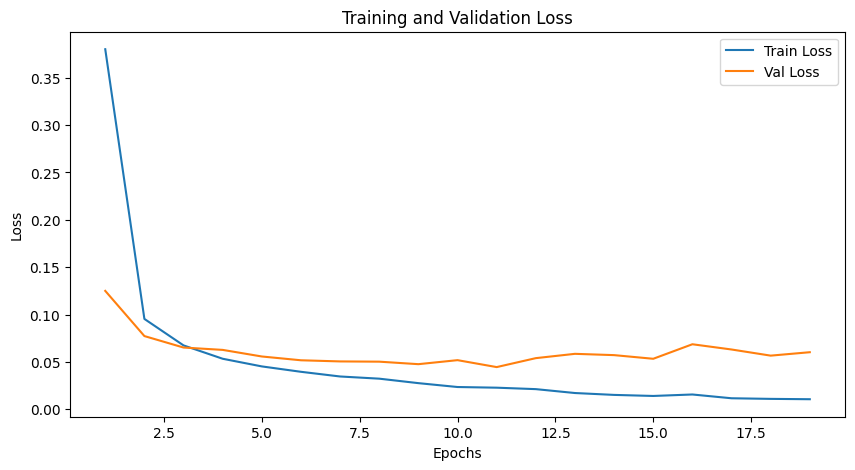

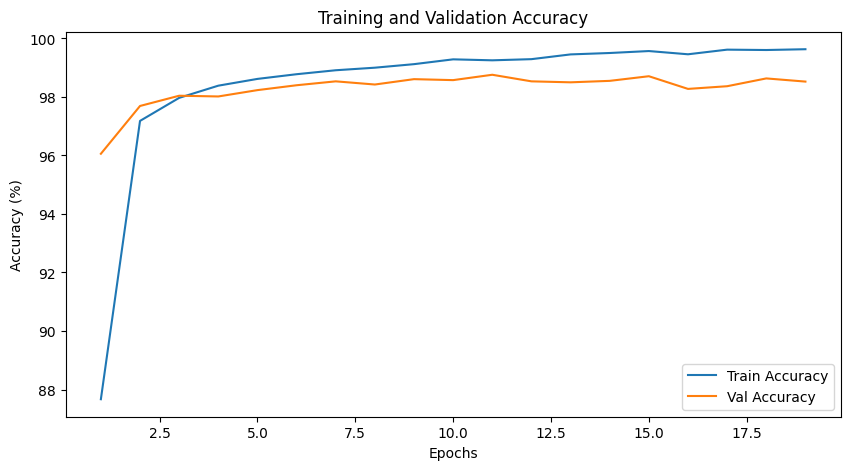

In [ ]:
save_path = 'Cnet_trained_model_3.pt'
optimizer_3 = optim.Adam(Cnet.parameters(), lr = learning_rate)

Cnet.reset_weights()

my_train(Cnet, num_epochs = 50, patience=10, save_path=save_path , dropout_rate = 0.5,
         loaders = data_loaders, optimizer = optimizer_3, loss_func = loss_func)

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

# torch.save(Cnet, "Cnet_1_trained_model.pt")

# !cp  CNN_1_trained_model.pt /content/drive/MyDrive/Sxoli/EFREMIDIS

# cnn = torch.load('/content/drive/MyDrive/Sxoli/EFREMIDIS/CNN_1_trained_model.pt')

# cnn = torch.load('CNN_1_trained_model.pt')

## train loop 3

In [ ]:
from torch.autograd import Variable

def train_with_early_stopping(num_epochs, model, loaders, patience=5):

    model.reset_weights()

    model.train()

    model.dropout_p = 0.8

    total_step = len(loaders['train'])
    best_val_loss = float('inf')
    no_improvement_count = 0

    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(loaders['train']):
            b_x = Variable(images).to(device)   # batch x
            b_y = Variable(labels).to(device)   # batch y

            output = model(b_x)
            loss = loss_func(output, b_y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if (i+1) % 100 == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                       .format(epoch + 1, num_epochs, i + 1, total_step, loss.item()))

        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, labels in loaders['valid']:
                b_x = Variable(images).to(device)   # batch x
                b_y = Variable(labels).to(device)   # batch y
                output = model(b_x)
                val_loss += loss_func(output, b_y).item()
            val_loss /= len(loaders['valid'])

        print(f"Epoch [{epoch + 1}/{num_epochs}], Val Loss: {val_loss:.4f}")

        # Early stopping
        if val_loss < best_val_loss * 0.9:
            best_val_loss = val_loss
            no_improvement_count = 0
        else:
            no_improvement_count += 1
            if no_improvement_count >= patience:
                print(f"No improvement in validation loss for {patience} epochs. Stopping training.")
                return

    print("Training completed.")


In [ ]:
save_path = 'Cnet_trained_model_5.pt'
optimizer = optim.Adam(Cnet.parameters(), lr = learning_rate)

model = Cnet
num_epochs = 10

Cnet.dropout_p = 0.3

# train_with_early_stopping(num_epochs, model, loaders, patience=5)

Dropout rate changed to: 0.3


## test

In [ ]:
%%capture
%pip install scikit-learn

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np

def test(model, loaders):
    model.eval()
    with torch.no_grad():
        all_predicted_labels = []
        all_true_labels = []

        for images, labels in test_loaders['test']:
            images = images.to(device)  # Move images to GPU
            labels = labels.to(device)  # Move labels to GPU

            test_output = model(images)
            pred_y = torch.max(test_output, 1)[1].data.squeeze().cpu()  # Move predictions back to CPU

            all_predicted_labels.extend(pred_y.tolist())
            all_true_labels.extend(labels.tolist())

        # Calculate Test Accuracy
        accuracy = (torch.tensor(all_predicted_labels) == torch.tensor(all_true_labels)).float().mean().item()
        print('Test Accuracy of the model on the test set: %.2f' % accuracy)

        # Calculate Confusion Matrix
        cm = confusion_matrix(all_true_labels, all_predicted_labels)
        print('Confusion Matrix:\n', cm)

        # Calculate accuracy for each class
        class_accuracies = np.diag(cm) / cm.sum(axis=1)
        for i, acc in enumerate(class_accuracies):
            print(f'Accuracy for class {i}: {acc:.2f}')

        # Visualize wrongly predicted images
        #visualize_wrong_predictions(images, all_predicted_labels, all_true_labels)

    return all_predicted_labels, all_true_labels

In [ ]:
path = 'Cnet_trained_model_5.pt'
# torch.save(cnn, path )
# cnn = torch.load(path)

In [ ]:
all_predicted_labels, all_true_labels = test(Cnet, data_loaders)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Test Accuracy of the model on the test set: 0.99
Confusion Matrix:
 [[ 973    0    2    1    0    0    1    0    2    1]
 [   0 1126    2    5    0    0    0    0    2    0]
 [   1    1 1025    2    1    0    0    2    0    0]
 [   0    0    0 1007    0    2    0    0    1    0]
 [   0    1    2    0  965    0    1    0    1   12]
 [   1    0    0    9    0  881    1    0    0    0]
 [   4    3    1    1    1    6  942    0    0    0]
 [   0    1   10    3    0    0    0 1008    1    5]
 [   1    0    4    2    0    1    0    0  965    1]
 [   0    0    2    5    3    4    0    0    1  994]]
Accuracy for class 0: 0.99
Accuracy for class 1: 0.99
Accuracy for class 2: 0.99
Accuracy for class 3: 1.00
Accuracy for class 4: 0.98
Accuracy for class 5: 0.99
Accuracy for class 6: 0.98
Accuracy for class 7: 0.98
Accuracy for class 8: 0.99
Accuracy for class 9: 0.99


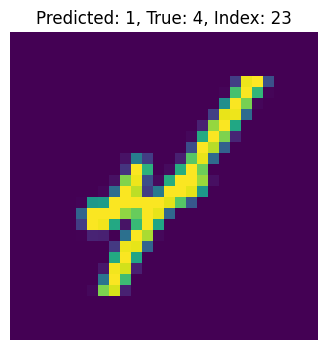

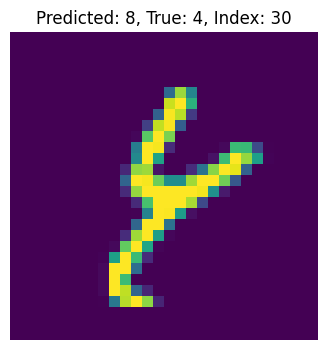

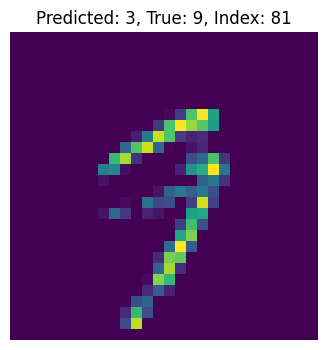

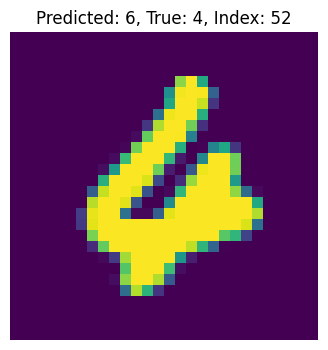

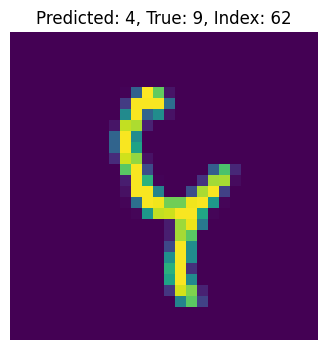

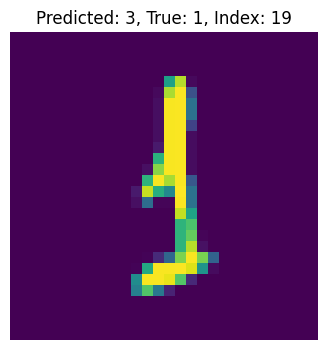

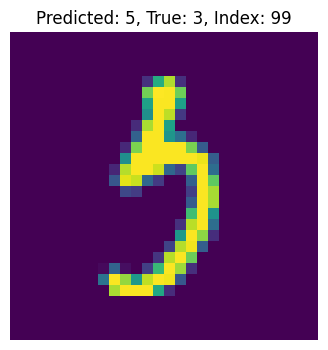

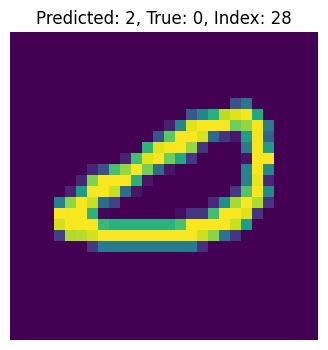

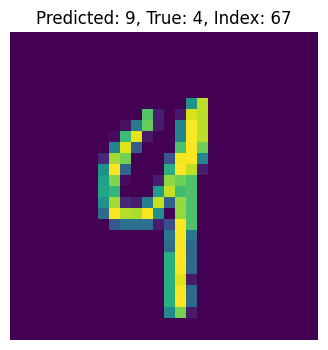

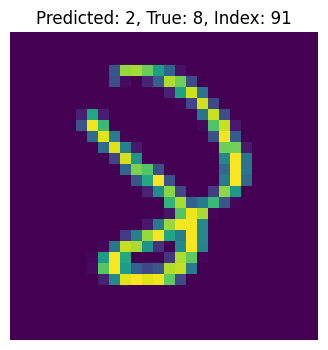

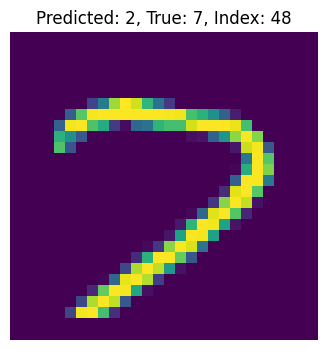

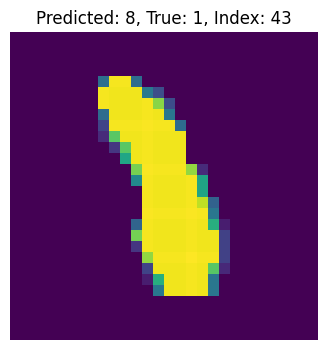

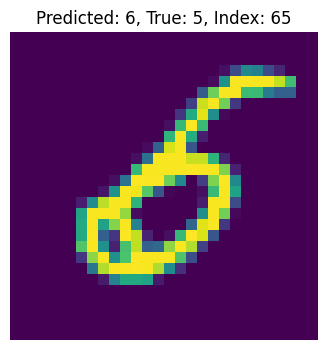

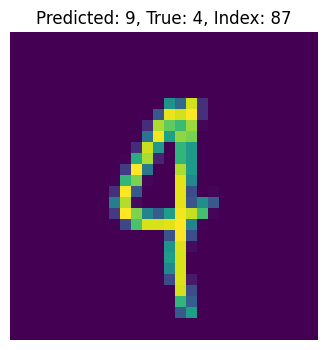

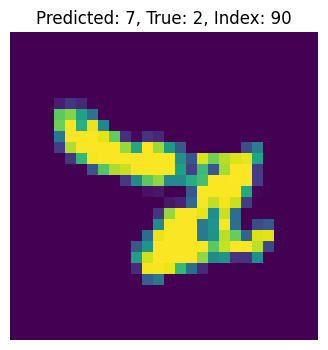

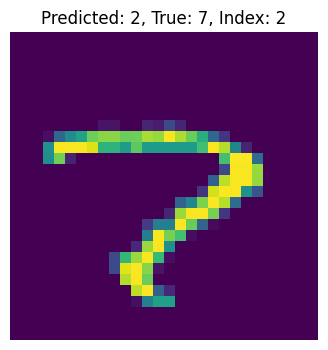

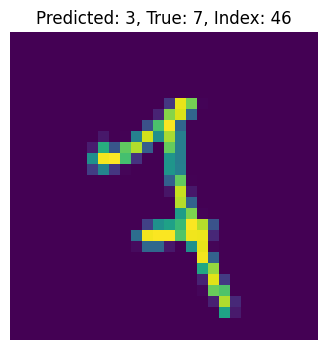

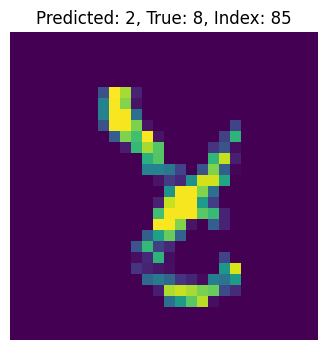

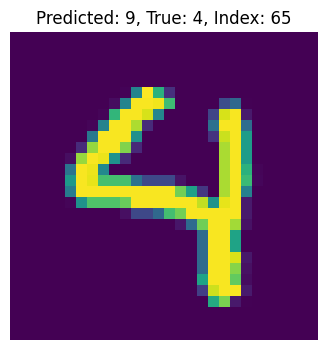

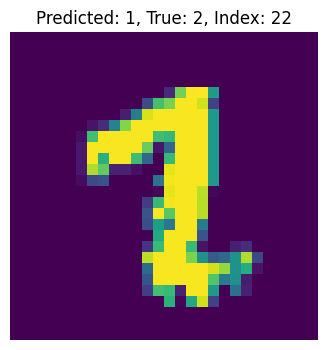

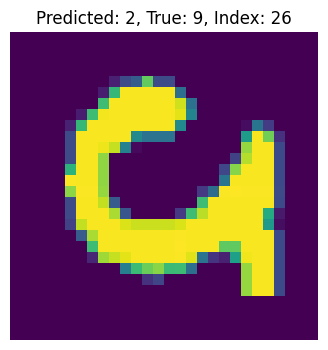

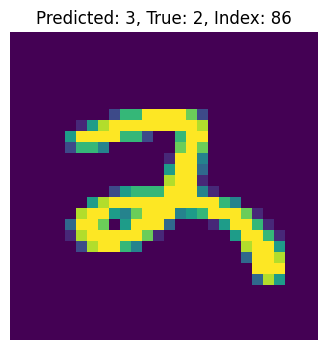

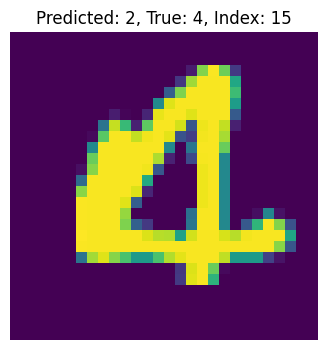

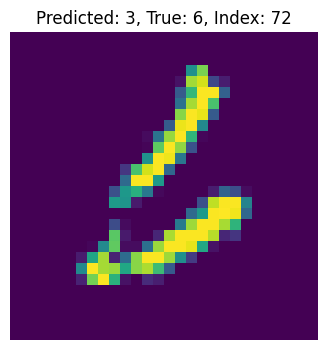

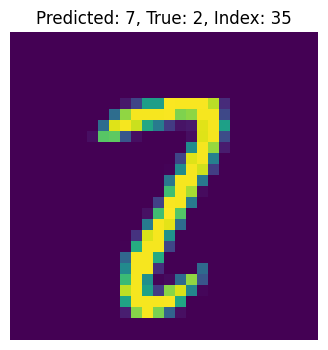

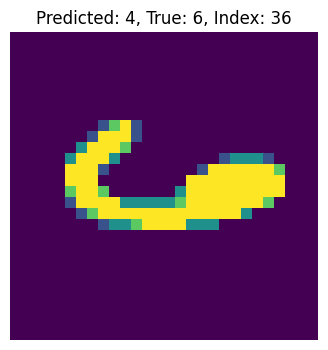

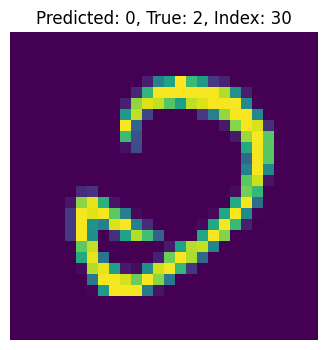

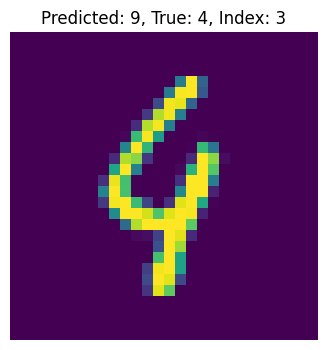

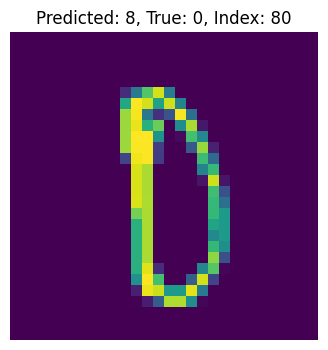

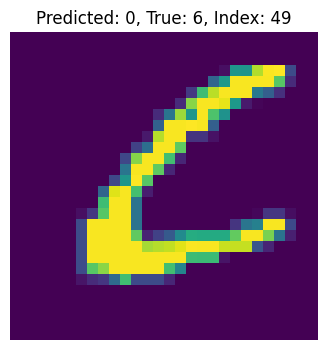

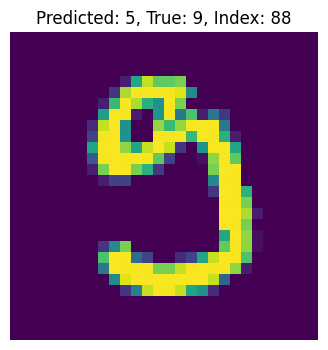

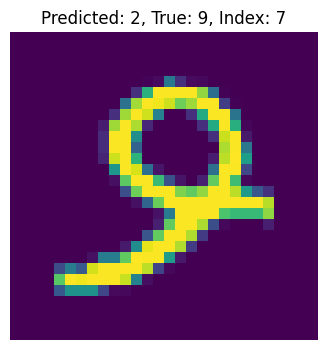

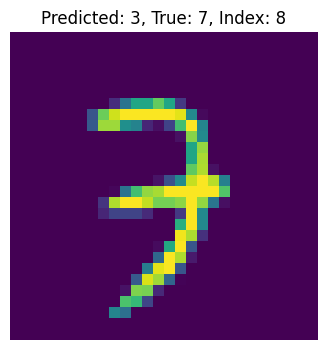

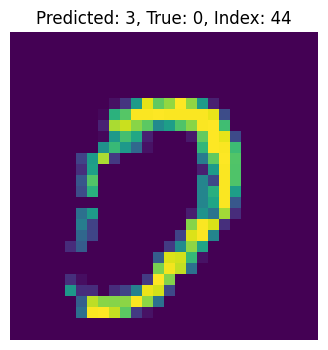

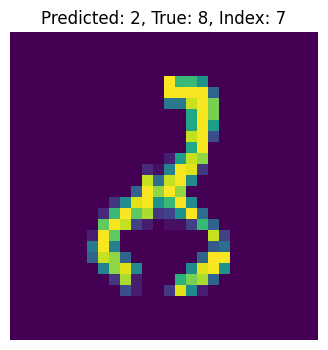

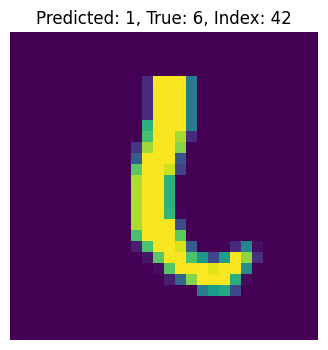

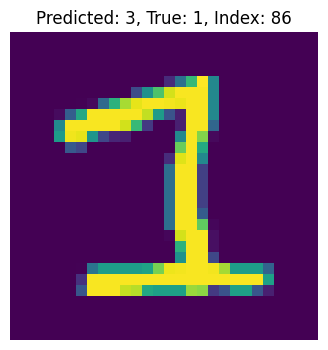

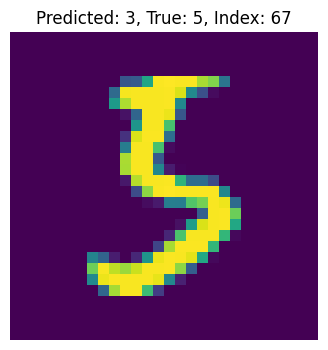

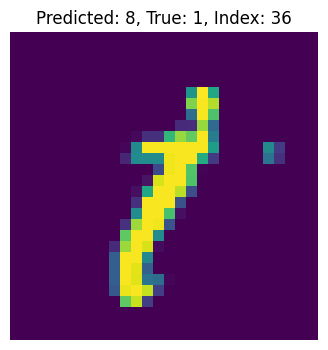

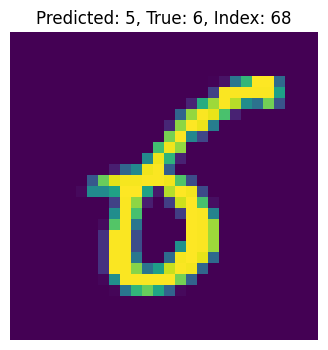

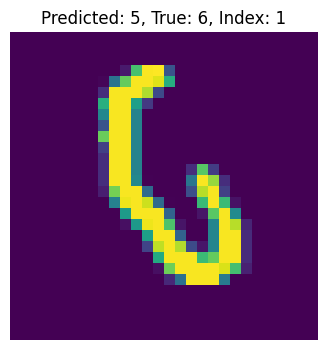

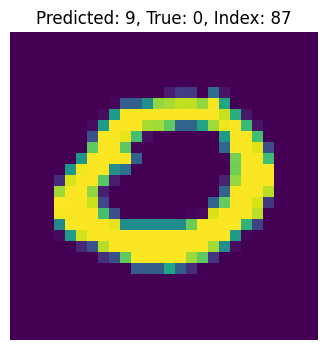

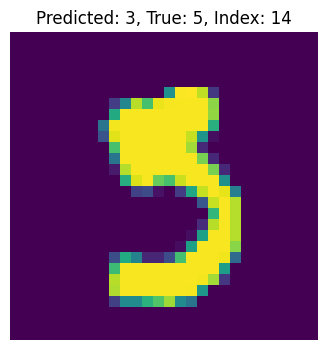

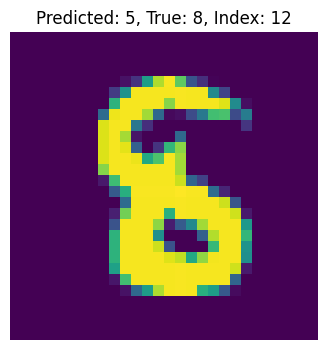

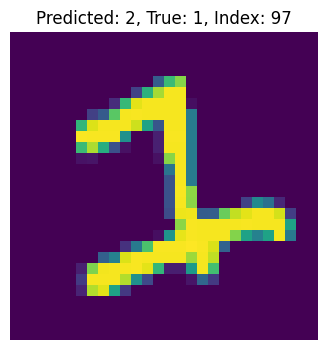

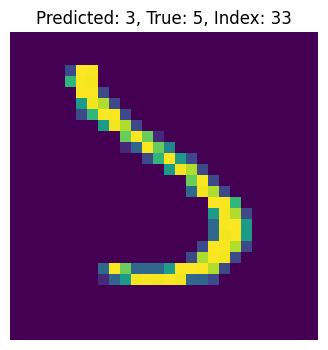

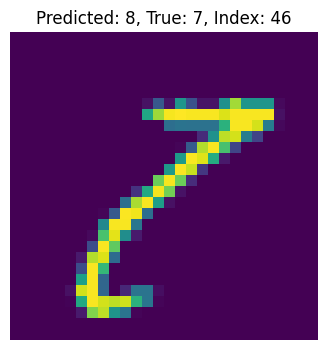

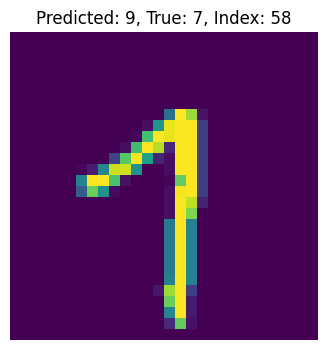

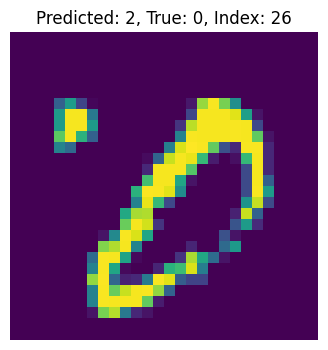

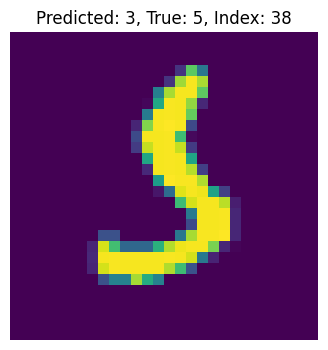

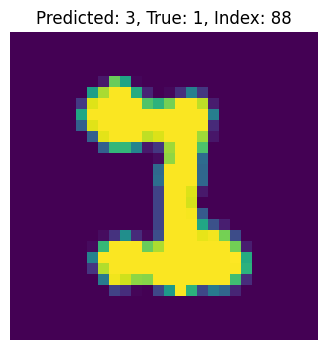

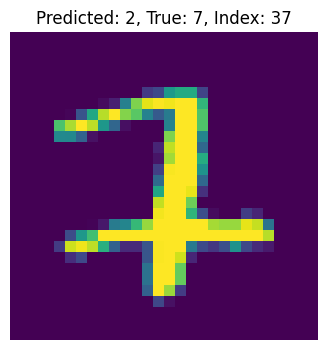

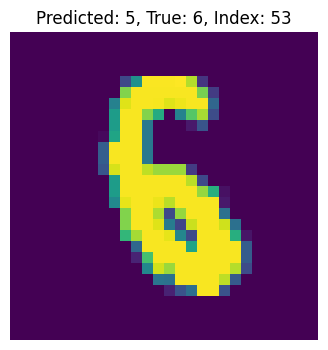

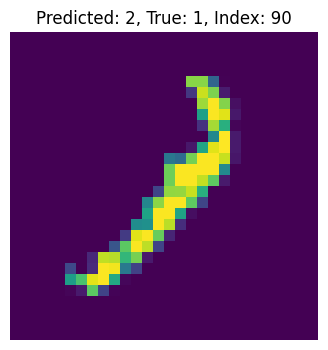

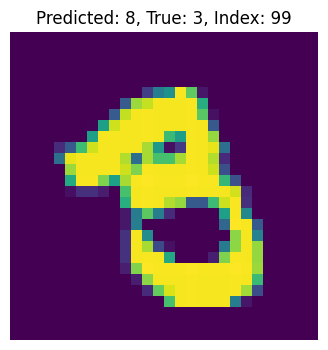

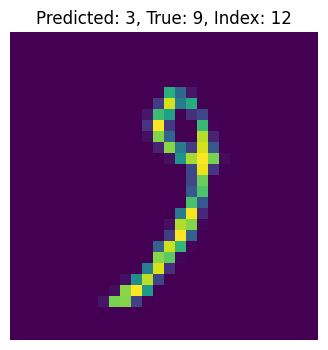

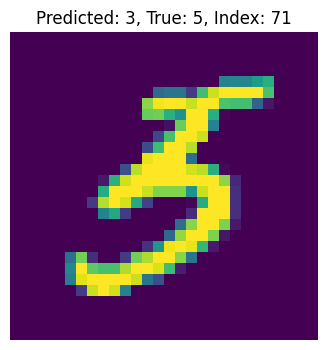

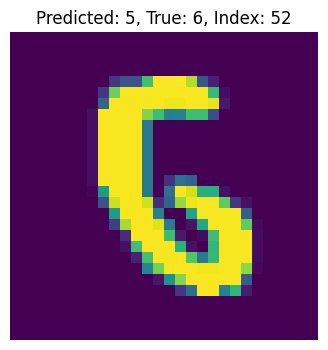

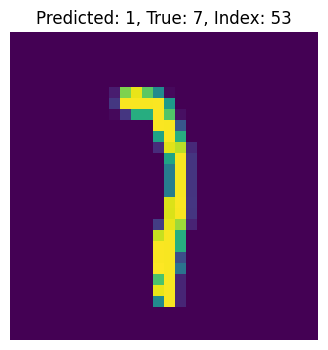

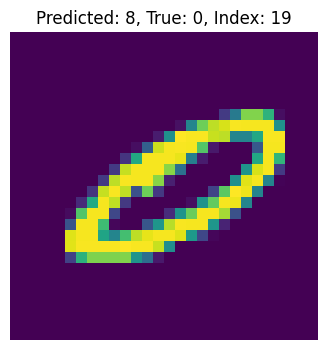

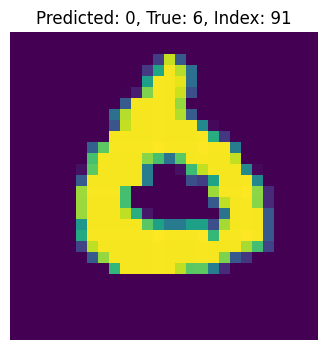

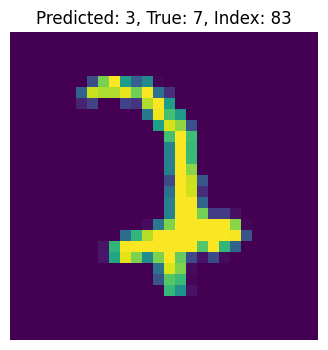

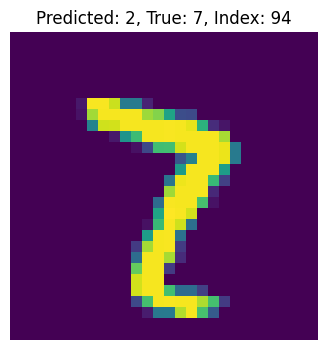

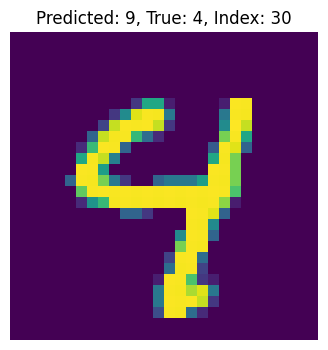

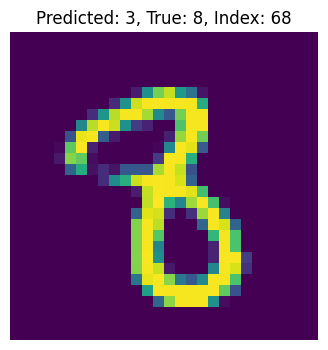

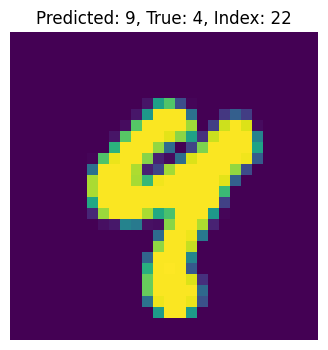

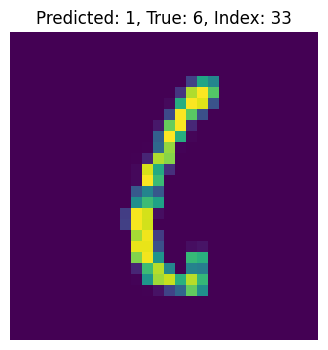

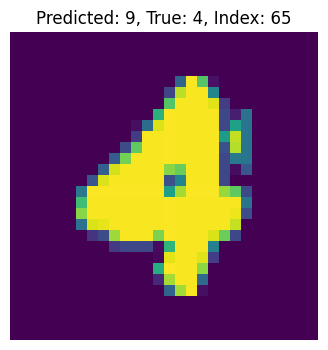

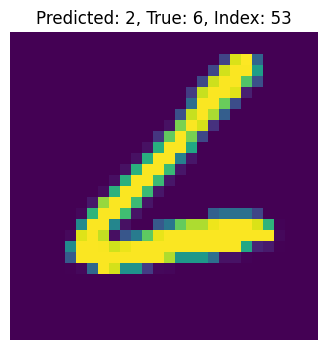

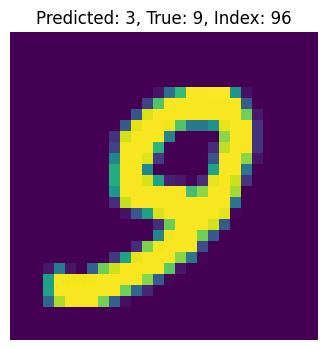

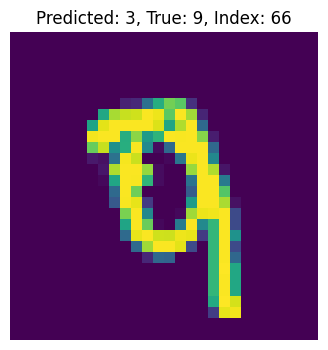

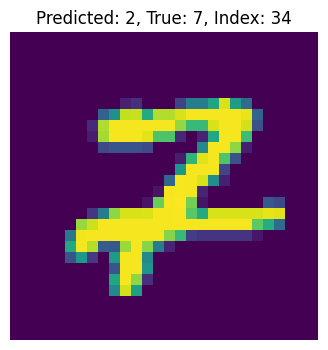

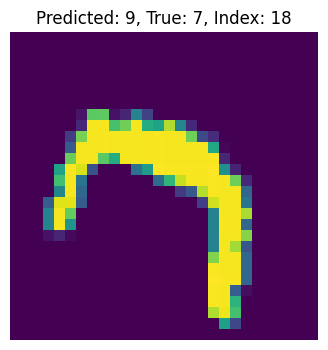

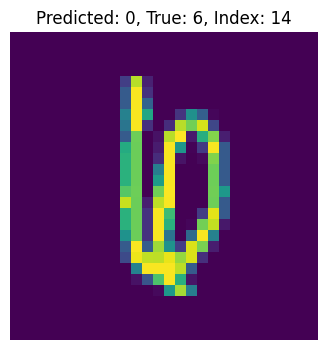

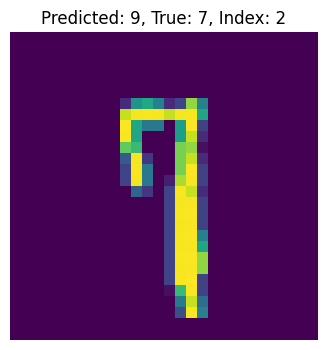

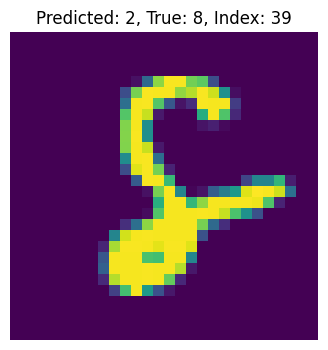

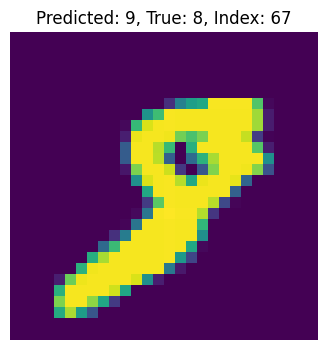

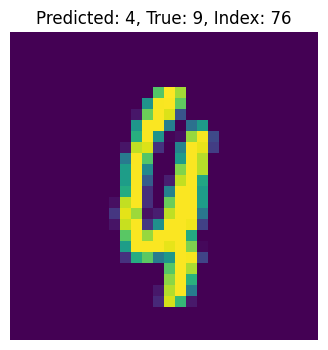

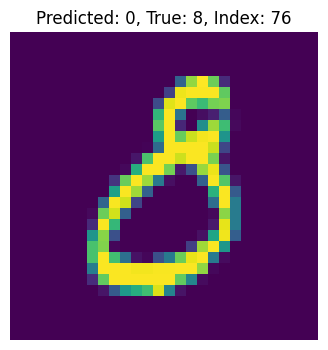

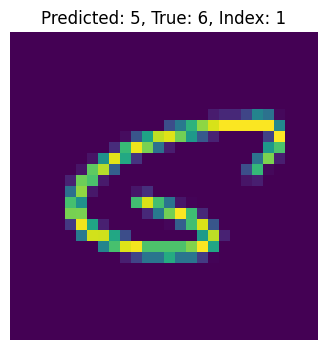

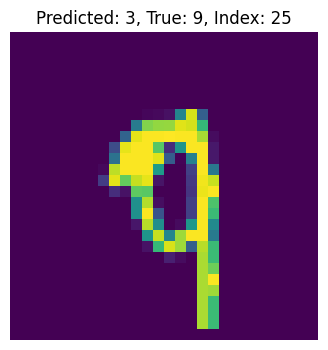

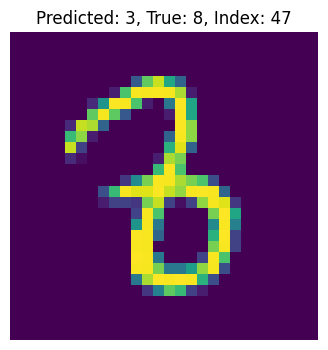

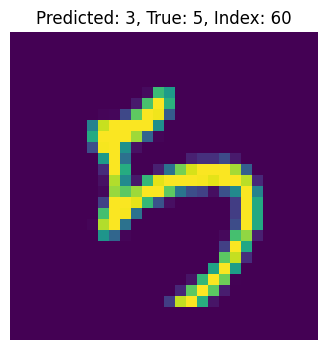

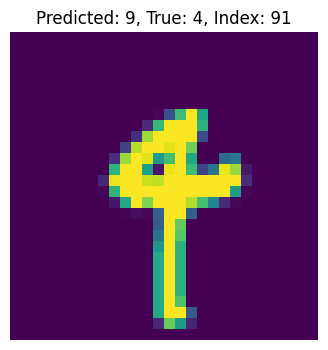

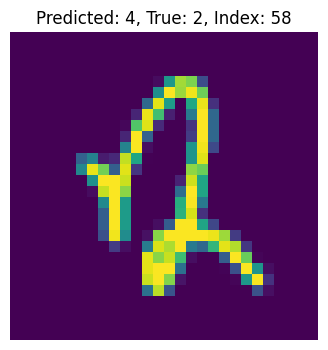

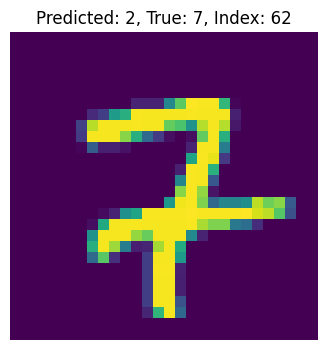

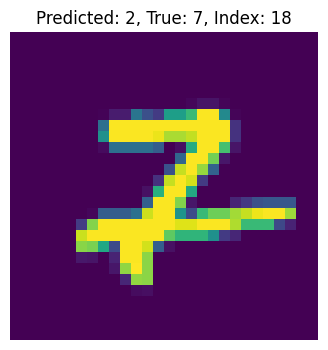

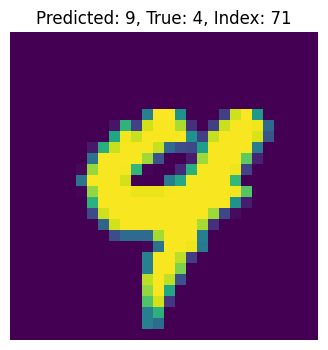

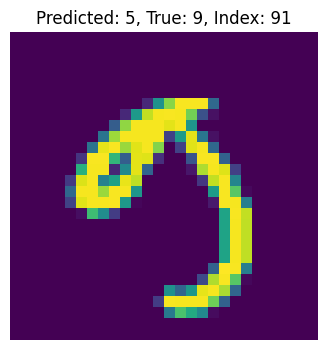

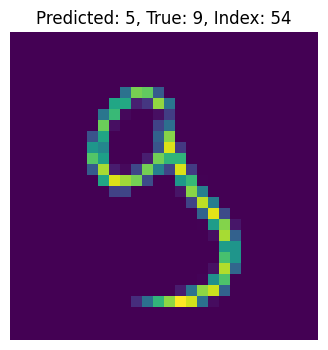

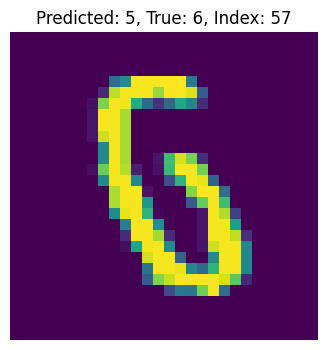

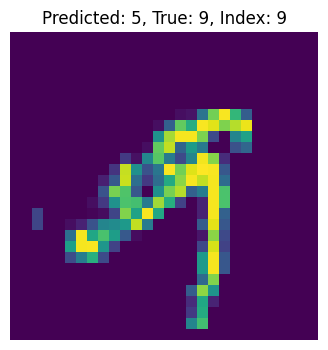

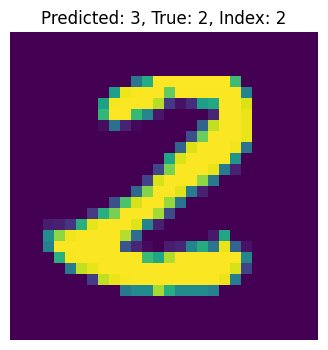

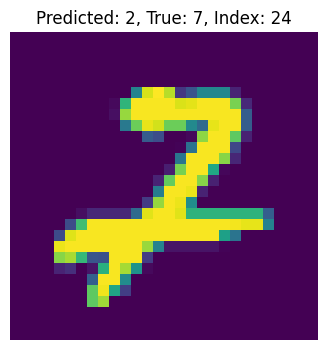

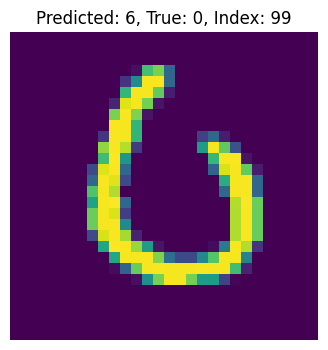

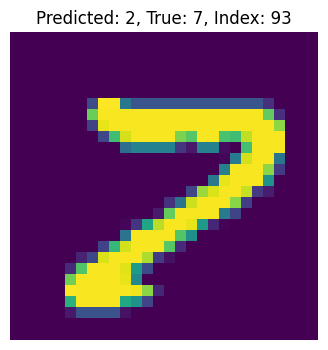

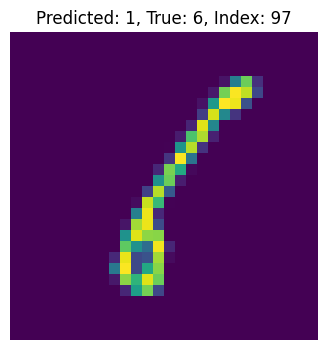

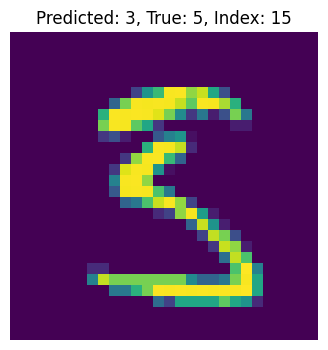

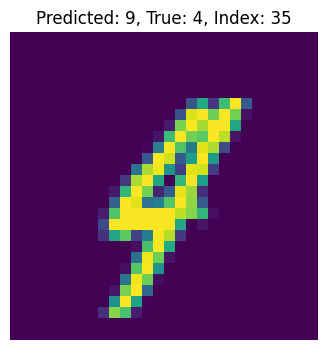

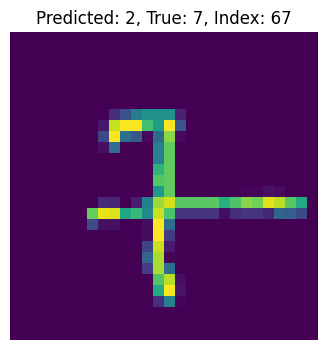

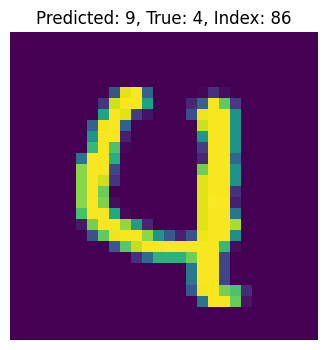

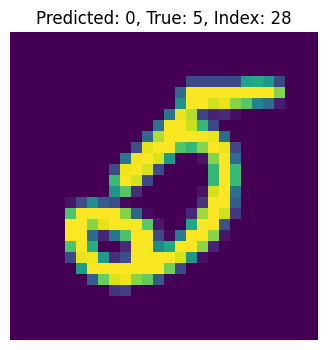

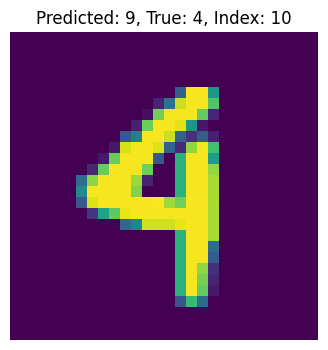

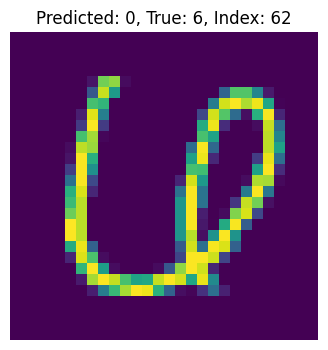

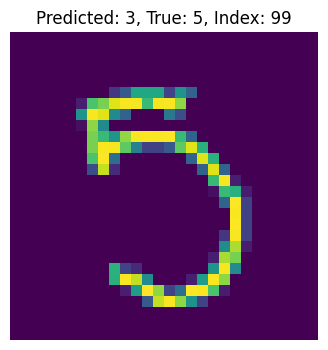

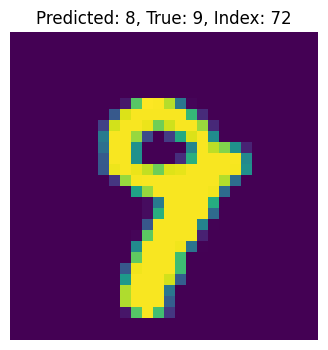

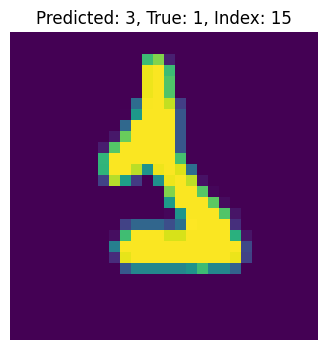

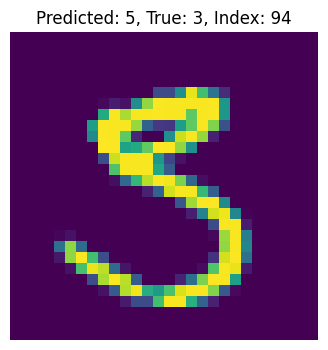

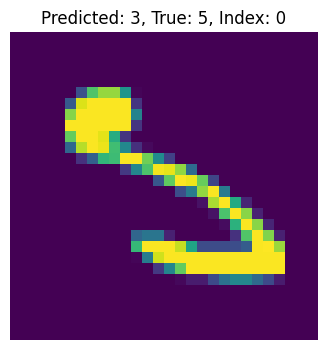

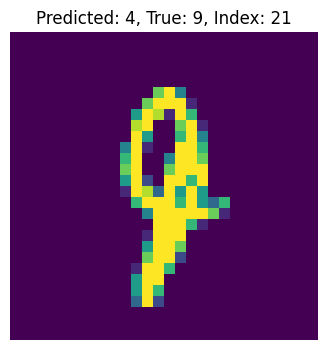

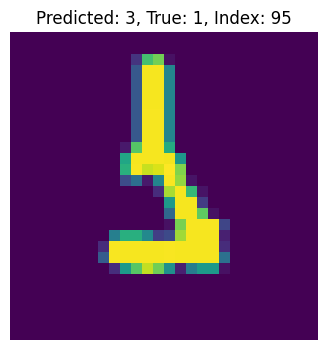

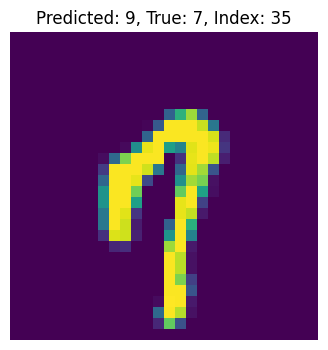

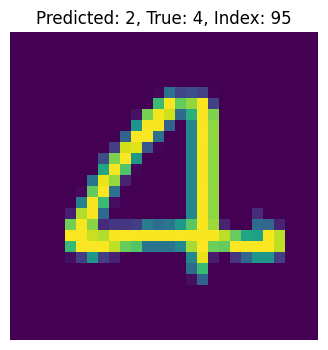

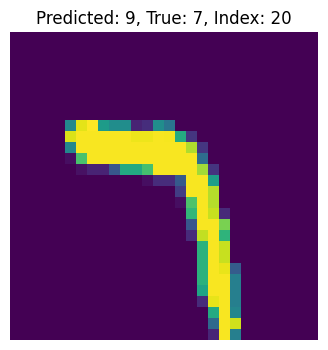

Total number of wrong predictions: 114


In [ ]:
import torch
import matplotlib.pyplot as plt

def wrong_images(model, data_loaders, device):
    model.eval()
    with torch.no_grad():
        wrong_sum = 0

        for images, labels in data_loaders['test']:
            images, labels = images.to(device), labels.to(device)
            test_output = model(images)
            pred_y = torch.max(test_output, 1)[1].data.squeeze()

            wrong_indices = (pred_y != labels).nonzero(as_tuple=True)[0]
            wrong_indices = wrong_indices[:20]

            wrong_sum += len(wrong_indices)

            for i, idx in enumerate(wrong_indices):
                wrong_image = images[idx].cpu().permute(1, 2, 0)
                wrong_predicted_label = pred_y[idx].item()
                wrong_true_label = labels[idx].item()

                plt.figure(figsize=(4, 4))
                plt.imshow(wrong_image)
                plt.title(f"Predicted: {wrong_predicted_label}, True: {wrong_true_label}, Index: {idx}")
                plt.axis('off')
                plt.show()

        print(f'Total number of wrong predictions: {wrong_sum}')

# Call the function with appropriate arguments
wrong_images(Cnet, data_loaders, device)
